<a href="https://colab.research.google.com/github/adrien50/time-series-forescasting-deeplearning/blob/main/Time_Series_Forecasting_Using_Deep_Learning_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Description
The problem we are going to look at in this post is theInternational Airline Passengers prediction problem.

This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

## Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

 ## Load and plot the whole dataset

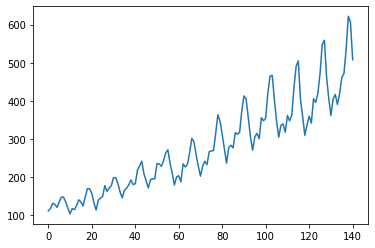

In [ ]:
import numpy
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
dataset = pandas.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',usecols=[1],engine='python',skipfooter=3)
plt.plot(dataset)
plt.show()

You can see an upward trend in the dataset over time.

## Long Short-Term Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

* Forget Gate: conditionally decides what information to throw away from the block.

* Input Gate: conditionally decides which values from the input to update the memory state.

*Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

## LSTM Network for Regression

We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

Before we get started, let’s first import all of the functions and classes we intend to use. This assumes a working SciPy environment with the Keras deep learning library installed.

In [ ]:
# for reproducability of the results let's fix the seed function
numpy.random.seed(1234)

In [ ]:
dataset.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [ ]:
# convert the integer values to floating point values, which are more suitable for modeling with a neural network.
dataset = dataset.values
dataset = dataset.astype('float32')

In [ ]:
# normaliza the dataset because LSTMs are sensitive to the scale of the input data
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [ ]:
dataset

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [ ]:
# After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data.
# split the dataset into train and test 
# split into train and test sets
train_size = int(len(dataset) * 0.67) # 67% of the observations is use to train our model, leaving the remaining 33% for testing the model.
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

94 47


## Define a function to create a new dataset

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [ ]:
# create dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return numpy.array(dataX),numpy.array(dataY)

## prepare the train and test datasets for modeling.

In [ ]:
#reshape the dataset X =current time, and Yt+1 =future time period
look_back =1
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)

In [ ]:
## We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows
trainX = numpy.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = numpy.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [ ]:
print(testX)

[[[0.3223938 ]]

 [[0.3899614 ]]

 [[0.4073359 ]]

 [[0.3803089 ]]

 [[0.48648646]]

 [[0.47104248]]

 [[0.484556  ]]

 [[0.6138996 ]]

 [[0.6969112 ]]

 [[0.70077217]]

 [[0.57915056]]

 [[0.46911195]]

 [[0.38803086]]

 [[0.44787642]]

 [[0.45559844]]

 [[0.4131274 ]]

 [[0.4980695 ]]

 [[0.47104248]]

 [[0.49999997]]

 [[0.6389961 ]]

 [[0.7471043 ]]

 [[0.7741313 ]]

 [[0.57915056]]

 [[0.492278  ]]

 [[0.3976834 ]]

 [[0.44980696]]

 [[0.49420848]]

 [[0.45945945]]

 [[0.5830116 ]]

 [[0.5637065 ]]

 [[0.61003864]]

 [[0.71042466]]

 [[0.8571429 ]]

 [[0.8783784 ]]

 [[0.69305015]]

 [[0.5849421 ]]

 [[0.4980695 ]]

 [[0.58108103]]

 [[0.6042471 ]]

 [[0.554054  ]]

 [[0.60810804]]

 [[0.6891892 ]]

 [[0.71042466]]

 [[0.8320464 ]]

 [[1.        ]]]


## We are now ready to design and fit our LSTM network for this problem
The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [ ]:
# let's create  a RNN or LSTM model
model = Sequential()
model.add(LSTM(4,input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# fit the model
model.fit(trainX,trainY,batch_size=1,verbose=2)

92/92 - 0s - loss: 0.0398


Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
print(trainPredict)

[[0.08938377]
 [0.09027235]
 [0.09235495]
 [0.09190762]
 [0.09071755]
 [0.09280284]
 [0.09474999]
 [0.09474999]
 [0.09295227]
 [0.09042069]
 [0.08820282]
 [0.09027235]
 [0.08982775]
 [0.09146087]
 [0.09370027]
 [0.09280284]
 [0.09131207]
 [0.09490018]
 [0.09806695]
 [0.09806695]
 [0.09625444]
 [0.09250419]
 [0.08967969]
 [0.09355055]
 [0.09429976]
 [0.09505042]
 [0.09927939]
 [0.09700873]
 [0.09836975]
 [0.09927939]
 [0.10247637]
 [0.10247637]
 [0.10019076]
 [0.09685776]
 [0.09444977]
 [0.09746194]
 [0.09821833]
 [0.09958299]
 [0.10156094]
 [0.09973486]
 [0.10003874]
 [0.10538494]
 [0.10722882]
 [0.10907742]
 [0.10400543]
 [0.10125613]
 [0.09836975]
 [0.1017134 ]
 [0.10201845]
 [0.10201845]
 [0.10815257]
 [0.10799854]
 [0.10707498]
 [0.10923167]
 [0.11247711]
 [0.11371626]
 [0.10830663]
 [0.10431172]
 [0.09958299]
 [0.10278185]
 [0.1032404 ]
 [0.10079927]
 [0.10799854]
 [0.10676739]
 [0.10784452]
 [0.11247711]
 [0.1183736 ]
 [0.11697492]
 [0.11170337]
 [0.10707498]
 [0.10308751]
 [0.10

In [ ]:
print(testPredict)

[[0.11356129]
 [0.11899558]
 [0.12039562]
 [0.11821814]
 [0.12677939]
 [0.12553352]
 [0.12662365]
 [0.13704003]
 [0.14368585]
 [0.14399381]
 [0.13424681]
 [0.12537777]
 [0.11884007]
 [0.12366472]
 [0.12428764]
 [0.12086245]
 [0.12771368]
 [0.12553352]
 [0.12786938]
 [0.1390537 ]
 [0.14768003]
 [0.14982152]
 [0.13424681]
 [0.12724654]
 [0.11961772]
 [0.12382045]
 [0.12740226]
 [0.1245991 ]
 [0.13455746]
 [0.1330038 ]
 [0.13672997]
 [0.14476323]
 [0.1563519 ]
 [0.15800977]
 [0.14337775]
 [0.13471273]
 [0.12771368]
 [0.13440213]
 [0.13626468]
 [0.13222653]
 [0.13657488]
 [0.14306957]
 [0.14476323]
 [0.15438566]
 [0.16738904]]


In [ ]:
# reverse the predicted values to the actual time series values using inverse tranform function to ensure that performance is reported in the same units as the original data
trainPredict = scaler.inverse_transform(trainPredict) 
testPredict = scaler.inverse_transform(testPredict)

trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [ ]:
print(trainPredict, trainY)

[[150.30078]
 [150.76108]
 [151.83986]
 [151.60815]
 [150.9917 ]
 [152.07188]
 [153.08049]
 [153.08049]
 [152.14928]
 [150.83792]
 [149.68906]
 [150.76108]
 [150.53078]
 [151.37672]
 [152.53673]
 [152.07188]
 [151.29965]
 [153.15828]
 [154.79869]
 [154.79869]
 [153.8598 ]
 [151.91716]
 [150.45409]
 [152.45918]
 [152.84727]
 [153.23611]
 [155.42671]
 [154.25052]
 [154.95554]
 [155.42671]
 [157.08275]
 [157.08275]
 [155.89882]
 [154.17232]
 [152.92499]
 [154.48529]
 [154.87709]
 [155.584  ]
 [156.60855]
 [155.66266]
 [155.82007]
 [158.5894 ]
 [159.54453]
 [160.5021 ]
 [157.87482]
 [156.45068]
 [154.95554]
 [156.68753]
 [156.84555]
 [156.84555]
 [160.02303]
 [159.94324]
 [159.46484]
 [160.58202]
 [162.26314]
 [162.90503]
 [160.10283]
 [158.03348]
 [155.584  ]
 [157.24101]
 [157.47853]
 [156.21402]
 [159.94324]
 [159.30551]
 [159.86345]
 [162.26314]
 [165.31752]
 [164.593  ]
 [161.86235]
 [159.46484]
 [157.39934]
 [159.46484]
 [160.5021 ]
 [159.7837 ]
 [162.50375]
 [162.66423]
 [162.74448]

In [ ]:
print(testPredict, testY)

[[162.82475]
 [165.63971]
 [166.36494]
 [165.237  ]
 [169.67174]
 [169.02637]
 [169.59105]
 [174.98674]
 [178.42928]
 [178.5888 ]
 [173.53984]
 [168.9457 ]
 [165.55916]
 [168.05832]
 [168.381  ]
 [166.60675]
 [170.15569]
 [169.02637]
 [170.23634]
 [176.02982]
 [180.49825]
 [181.60754]
 [173.53984]
 [169.9137 ]
 [165.96199]
 [168.13899]
 [169.99438]
 [168.54233]
 [173.70076]
 [172.89597]
 [174.82613]
 [178.98735]
 [184.99028]
 [185.84906]
 [178.26967]
 [173.78119]
 [170.15569]
 [173.6203 ]
 [174.58511]
 [172.49335]
 [174.74579]
 [178.11003]
 [178.98735]
 [183.97177]
 [190.70752]] [[306.00000422 315.00000344 301.00001152 355.999993   348.00001085
  355.00000681 421.9999924  465.0000161  466.99998848 403.99999397
  346.99999379 304.99998716 335.99999132 339.99999783 317.99999288
  362.00000277 348.00001085 362.99998896 434.99999813 491.00002756
  505.00001948 403.99999397 359.00001333 310.00001073 337.00000838
  359.99999952 342.00000109 406.0000281  395.99998094 420.00002002
  471.999981

In [ ]:
# calculate the RMSE root mean square error
trainScore = math.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
print ('Train Score: %.2f RMSE' % (trainScore))

Train Score: 85.03 RMSE


In [ ]:
testScore = math.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print ('Test Score: %.2f RMSE' % (testScore))

Test Score: 246.47 RMSE


90/90 - 0s - loss: 0.0324
Train Score: 67.22 RMSE
Test Score: 197.19 RMSE


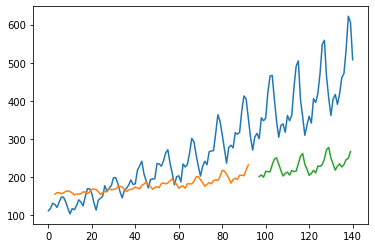

In [ ]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()